# Literacy vs Homicide rate analysis

We had a hypothesis that as literacy rates go up, homicide rates would go down. We will explore that hypothesis here to see if the data backs it up. Our first step is simply importing dependencies and our csv's as dataframes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
base_df = pd.read_csv("Homicides Are Falling Around the World - Homicides Are Falling Around the World.csv")
base_df = base_df.drop(columns= ["earliest figure", 'source', 'URL', 'latest figure'])
lit_df = pd.read_csv("API_SE.ADT.LITR.ZS_DS2_en_csv_v2_5728795.csv")
lit_df = lit_df.drop(columns = ["Country Code", "Indicator Code"])

Next, I would prefer my dataframes in a different format than the ones given, so I used a for loop to reorder it. Now instead of columns being years and rows being the rates, we have the years all in one column with the rates in another. The country names are repeated multiple times, once for each year they have on record.

In [3]:
reorderedbase = pd.DataFrame(columns = {"country":"", "year":"","rate":""})
temp = {}
temp["country"]=[]
temp["year"]=[]
temp["rate"] = []
for index, row in base_df.iterrows():
    temp["country"].append(base_df.iloc[index][0])
    temp["year"].append(base_df.iloc[index][2:].index.tolist())
    temp["rate"].append(base_df.iloc[index][2:].values.tolist())
    tempdf = pd.DataFrame({"country": temp["country"][index],"year":temp["year"][index],"rate":temp["rate"][index]})
    reorderedbase = pd.concat([reorderedbase,tempdf])
#pd.DataFrame({"country": tst["country"][0],"year":tst["year"][0],"rate":tst["rate"][0]})
reorderedbase = reorderedbase.reset_index()
reorderedbase

,index,country,year,rate
0,0,Croatia,1995,3.56
1,1,Croatia,1996,2.62
2,2,Croatia,1997,2.55
3,3,Croatia,1998,2.86
4,4,Croatia,1999,2.67
...,...,...,...,...
1255,16,Mexico,2011,22.60
1256,17,Mexico,2012,21.30
1257,18,Mexico,2013,18.60
1258,19,Mexico,2014,16.00


In [4]:
reorderedlit = pd.DataFrame(columns = {"country":"", "year":"","literacy":""})
temp= {}
temp["country"]=[]
temp["year"]=[]
temp["literacy"] = []
for index, row in lit_df.iterrows():
    temp["country"].append(lit_df.iloc[index][0])
    temp["year"].append(lit_df.iloc[index][2:].index.tolist())
    temp["literacy"].append(lit_df.iloc[index][2:].values.tolist())
    tempdf = pd.DataFrame({"country": temp["country"][index],"year":temp["year"][index],"literacy":temp["literacy"][index]})
    reorderedlit = pd.concat([reorderedlit,tempdf])
#pd.DataFrame({"country": tst["country"][0],"year":tst["year"][0],"rate":tst["rate"][0]})
reorderedlit = reorderedlit.reset_index()
reorderedlit

,index,country,year,literacy
0,0,Aruba,1960,NaN
1,1,Aruba,1961,NaN
2,2,Aruba,1962,NaN
3,3,Aruba,1963,NaN
4,4,Aruba,1964,NaN
...,...,...,...,...
16753,58,Zimbabwe,2018,NaN
16754,59,Zimbabwe,2019,NaN
16755,60,Zimbabwe,2020,NaN
16756,61,Zimbabwe,2021,89.699997


Next, the reson I wanted to restructure the data like this, we can use groupby functions to fine the first and last year a country has data for both literacy and homicides, and then merge that back in.

In [5]:
merged_df = reorderedbase.merge(reorderedlit, on = ["country","year"], how = 'outer')
merged_df = merged_df.dropna()
grouped = merged_df.groupby("country")
maxtime = grouped["year"].max()
mintime = grouped["year"].min()
merged_df = merged_df.merge(maxtime,on = ["country"], how = 'outer')
merged_df = merged_df.merge(mintime,on = ["country"], how = 'outer')
merged_df = merged_df.loc[merged_df['year_y'] != merged_df['year']]
merged_df = merged_df.loc[merged_df['year_y'] != merged_df['year']]
merged_df = merged_df.drop(columns = ['index_x','index_y'])
merged_df = merged_df.rename(columns = {"year":"earliest year","year_y":"latest year","year_x":"index year"})
merged_df

,country,index year,rate,literacy,latest year,earliest year
0,Croatia,2001,1.80,98.146683,2011,2001
1,Croatia,2011,1.10,99.125359,2011,2001
3,Kazakhstan,1999,15.74,99.512657,2010,1999
4,Kazakhstan,2009,11.00,99.732407,2010,1999
5,Kazakhstan,2010,8.60,99.781631,2010,1999
...,...,...,...,...,...,...
143,Mexico,2011,22.60,93.519981,2015,2000
144,Mexico,2012,21.30,94.228401,2015,2000
145,Mexico,2013,18.60,93.962852,2015,2000
146,Mexico,2014,16.00,94.555878,2015,2000


This next code was adapted from Spencer's code in the freedom score analysis. We use it to find the percent change in literacy rate and later homicide rate.

In [17]:
country = []
percentliteracyscore = []
for i in merged_df["country"]:
        percentliteracyscore.append(((merged_df.loc[(merged_df["index year"] == merged_df["latest year"]) & (merged_df["country"] == i)]["literacy"].reset_index(drop=True) 
                                     - merged_df.loc[(merged_df["index year"] == merged_df.loc[merged_df["country"] == i]["index year"].min()) & (merged_df["country"] == i)]["literacy"].reset_index(drop=True)) 
                                    / merged_df.loc[(merged_df["index year"] == merged_df["earliest year"]) & (merged_df["country"] == i)]["literacy"].reset_index(drop=True)).iloc[0])
        country.append(i)      
percentliteracyscore = np.round(percentliteracyscore, 2)
percentliteracyscore = percentliteracyscore * 100
percentliteracyscore_df = pd.DataFrame({"Country": country,
                                      "% Change in lit rate": percentliteracyscore})
percentliteracyscore_df = percentliteracyscore_df.sort_values(by="% Change in lit rate", ascending=False)
percentliteracyscore_df = percentliteracyscore_df.rename(columns = {"% Change in lit rate":"% Change in literacy rate"})
percentliteracyscore_df

,Country,% Change in literacy rate
49,Morocco,45.0
45,Morocco,45.0
50,Morocco,45.0
47,Morocco,45.0
48,Morocco,45.0
...,...,...
115,Azerbaijan,0.0
116,Azerbaijan,0.0
117,Azerbaijan,0.0
118,Azerbaijan,0.0


In [18]:
country = []
percenthomiciderate = []
for i in merged_df["country"]:
        percenthomiciderate.append(((merged_df.loc[(merged_df["index year"] == merged_df["latest year"]) & (merged_df["country"] == i)]["rate"].reset_index(drop=True) 
                                     - merged_df.loc[(merged_df["index year"] == merged_df.loc[merged_df["country"] == i]["index year"].min()) & (merged_df["country"] == i)]["rate"].reset_index(drop=True)) 
                                    / merged_df.loc[(merged_df["index year"] == merged_df["earliest year"]) & (merged_df["country"] == i)]["rate"].reset_index(drop=True)).iloc[0])
        country.append(i)      
percenthomiciderate = np.round(percenthomiciderate, 2)
percenthomiciderate = percenthomiciderate * 100
percenthomiciderate_df = pd.DataFrame({"Country": country,
                                      "% Change in homicide rate": percenthomiciderate})
percenthomiciderate_df = percenthomiciderate_df.sort_values(by="% Change in homicide rate", ascending=False)
percenthomiciderate_df

,Country,% Change in homicide rate
110,Panama,112.0
109,Panama,112.0
7,Albania,77.0
8,Albania,77.0
9,Albania,77.0
...,...,...
20,Colombia,-63.0
12,Moldova,-69.0
13,Moldova,-69.0
6,Poland,-75.0


Next, combine them into one dataframe

In [20]:
combineddf = percenthomiciderate_df.merge(percentliteracyscore_df, on = "Country", how = 'outer')
combineddf = combineddf.loc[combineddf['% Change in literacy rate'] > 0.0]

The next part is also borrowed and adapted from Spencer's work, and includes a dual bar chart with red bars signifying the murder rate change and yellow bars signifying the change in literacy rates,

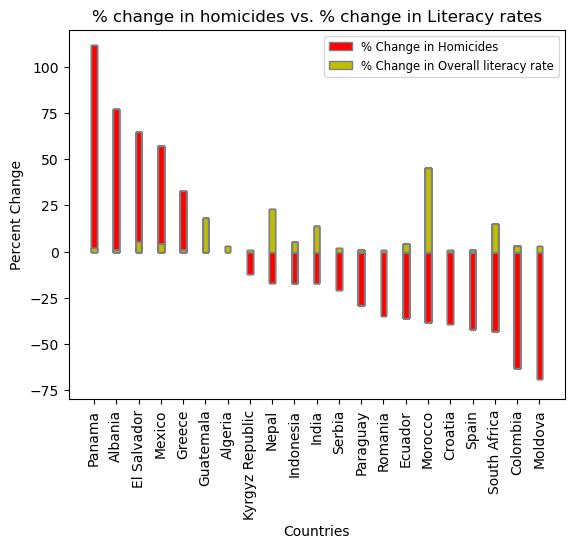

In [21]:
plt.bar(combineddf["Country"], combineddf["% Change in homicide rate"], color ='r', width = .25,
        edgecolor ='grey')
plt.bar(combineddf["Country"], combineddf["% Change in literacy rate"], color ='y', width = .25,
        edgecolor ='grey')
plt.ylim([-80, 120])
plt.legend(["% Change in Homicides","% Change in Overall literacy rate"],loc='best', fontsize = 'small')
plt.xlabel("Countries")
plt.ylabel("Percent Change")
plt.title("% change in homicides vs. % change in Literacy rates")
plt.xticks(rotation = 90)
plt.savefig("Images/Fig3.png")
plt.show()

These results are unexpected, and do not clearly support our hypothesis. We do not see a clear trend of homicide rates decreasing as literacy rates increase, and we even see a few countries where the opposite seems to happen.

Next, we check what countries have enough datapoints to be worth having isolated charts for.

In [22]:
merged_df.groupby("country").count()

,index year,rate,literacy,latest year,earliest year
country,,,,,
Albania,3,3,3,3,3
Algeria,2,2,2,2,2
Argentina,2,2,2,2,2
Azerbaijan,6,6,6,6,6
Belarus,2,2,2,2,2
Colombia,11,11,11,11,11
Croatia,2,2,2,2,2
Ecuador,9,9,9,9,9
El Salvador,8,8,8,8,8


In this case, we selected countries with 8 or more datapoints to work with

In [23]:
shortlist = ['Mexico','Colombia','Spain','Ecuador','El Salvador', 'South Africa']

This next cell is taken from a previous challenge I did, specifically the weatherpy challenge. It's a useful regression function that I figured would be nice to utilize here

In [24]:
def regression(x,y,xlabel,ylabel): #need x,y, as well as labels for axes.
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y) #relevant regression values
    regline = x*slope + intercept #regression line
    line_eq = "The regression line is y = " + str(round(slope,2))+"*x + " + str(round(intercept,2)) #string of line equation
    plt.plot(x,regline,"r-") #plot fit line
    plt.scatter(x,y) #scatter plot
    plt.annotate(line_eq,(min(x),min(y)), fontsize=10) #write fit line and place it at bottom of plot
    plt.annotate("The r value is " + str(round(rvalue,2)),(min(x),max(y)),fontsize = 10)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(ylabel + " vs. " + xlabel) #title for graph

Simply use the regression function to plot the points for the 6 countries chosen.

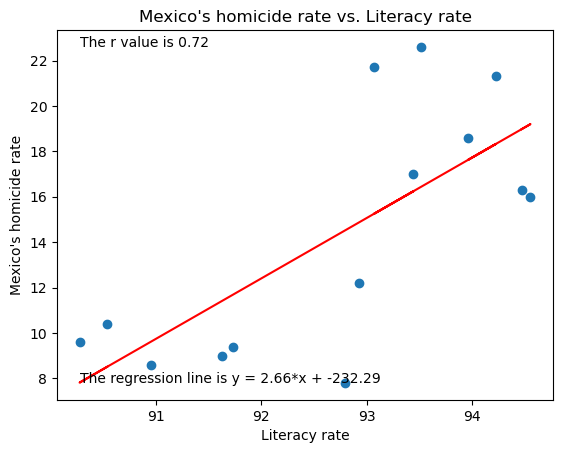

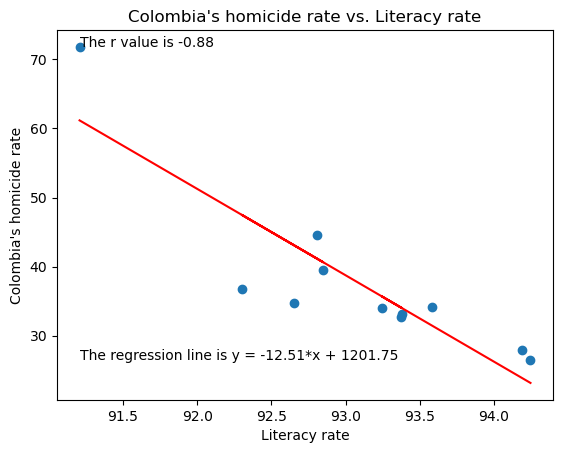

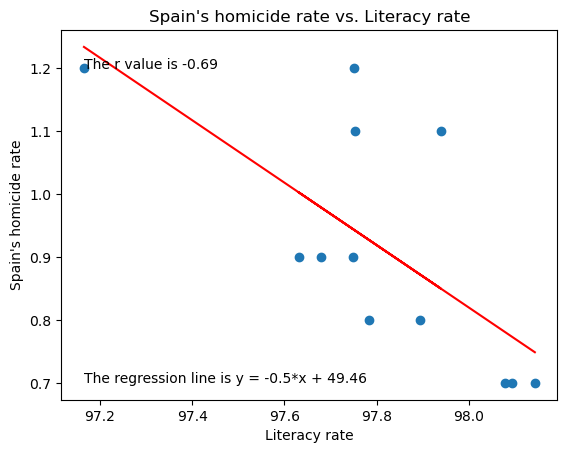

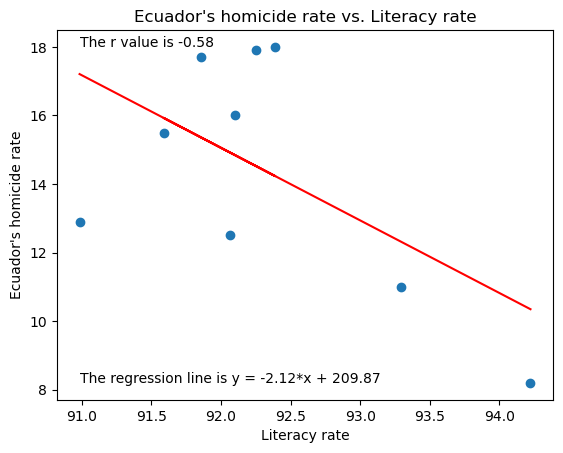

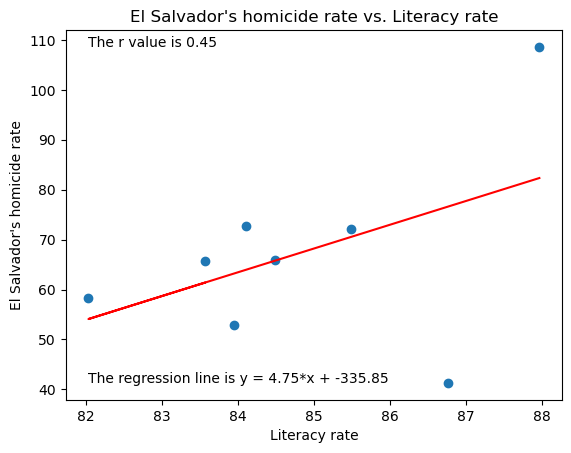

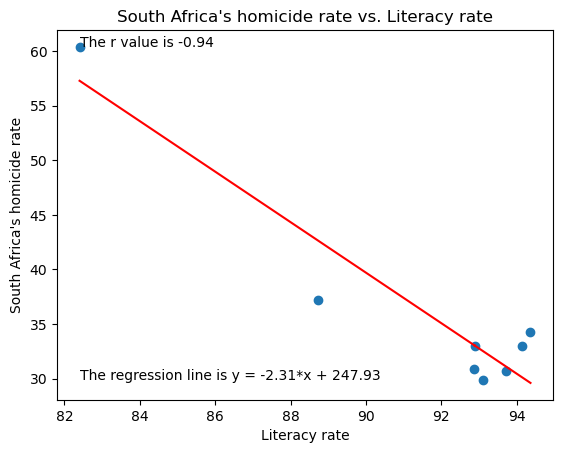

In [25]:
for i in range(len(shortlist)):
    regression(merged_df.loc[merged_df['country'] == shortlist[i]]['literacy'],merged_df.loc[merged_df['country'] == shortlist[i]]['rate'],
              "Literacy rate", shortlist[i] + "'s homicide rate")
    plt.savefig('Images/figure'+str(i)+".png")
    plt.show()

The results for this are a bit more promising, with some clearer negative correlations with South Africa and Colombia, but for the most part the correlations are not very strong, and some, like Mexico and El Salvador, are actually positive. Overall, it does not seem like a widespread correlation between literacy rates and homicide rates can be definitively drawn.

# Final notes and Analysis


The fourth question we examined was the correlation between homicide rates and literacy rates. Our hypothesis was that as literacy rates increased, homicide rates would decrease. Using homicide data () and literacy rate data () both from the World Bank, we imported, cleaned, organized, and merged our datasets before performing the analysis you see above.

Our hypothesis did not see clear support among our data. While there were some instances where the data seemed to support the idea of an inverse relationship between literacy rates and homicide, like with South Africa, overall and globally, there just didn't seem to be much support. One thing to note about this, however, is that our data for literacy rates is rather limited. We can only analyze data for which we have both homicide rate and literacy rate in the same year, and many countries only had a handful of datapoints that met that criteria. I personally believe this would benefit from another, more extensive, analysis. 